## Mathematische Grundlagen eines Neuronalen Netzes
Nachfolgender Programmcode dient dazu die mathematischen Grundlagen eines Neuronalen Netzes zu veranschaulichen. 
Hierzu wird ein Neuronalen Netz ohne zusätzliche Bibliotheken - mit Ausnahme von numpy zur Berechnung von Matrixoperationen - implementiert. 
Das nachfolgend implementiert Neuronale Netz verwendet die Sigmoid Aktivierungfunktion und berechnet den Gradienten der Kostenfunktion mithilfe des Backpropagation Algorithmus.

In [672]:
import numpy as np
import matplotlib.pyplot as plt

In [673]:
class NeuralNetwork():

    def __init__(self, layers: list[int]):
        self.weights = []
        self.biases = []
        self.layers = layers
        for i, layer in enumerate(layers):
            if i+1 != len(layers):
                # Xavier initialization for tanh
                limit = np.sqrt(6 / (layer + layers[i+1]))
                self.weights.append(np.random.uniform(-limit, limit, (layers[i+1], layer)))
                self.biases.append(np.zeros((layers[i+1], 1)))

    def set_random_parameters(self):
        self.weights = []
        self.biases = []
        for i, layer in enumerate(self.layers):
            if i+1 != len(self.layers):
                limit = np.sqrt(6 / (layer + self.layers[i+1]))
                self.weights.append(np.random.uniform(-limit, limit, (self.layers[i+1], layer)))
                self.biases.append(np.zeros((self.layers[i+1], 1)))

    def set_test_parameters(self, test_weights, test_biases):
        self.weights = []
        self.biases = []
        for weight_matrix in test_weights:
            self.weights.append(weight_matrix)
        for bias_vector in test_biases:
            self.biases.append(bias_vector)

    def train(self, X, Y, eta, epochs, test_X, test_Y, tolerance=1e-6):
        prev_mse = float('inf')  # Initialisiere vorherigen Fehler mit unendlich
        for i in range(epochs):
            self.gradient_descent(X, Y, eta)
            if i % 2000 == 0: # Print every 2000 epochs
                mse = self.evaluate(test_X, test_Y)
                print(f"Epoche {i} von {epochs}: MSE {mse}")
                
                # Abbruchbedingung: Überprüfe, ob die Änderung des Fehlers kleiner als die Toleranz ist
                if abs(prev_mse - mse) < tolerance:
                    print(f"Training beendet bei Epoche {i}, da die Änderung des Fehlers kleiner als {tolerance} ist.")
                    break
                
                prev_mse = mse  # Aktualisiere den vorherigen Fehler

    def evaluate(self, test_X, test_Y):
        N = len(test_X)
        error = 0
        for test_x, test_y in zip(test_X, test_Y):
            a, z = self.propagate_forward(a_0=test_x)
            y_pred = a[-1].item()
            error += (y_pred - test_y)**2
        mse = (1/N) * error
        return mse


    def gradient_descent(self, X, Y, eta):
        gradient_weights_sum = [np.zeros(weight_matrix.shape) for weight_matrix in self.weights]
        gradient_biases_sum = [np.zeros(bias_vectors.shape) for bias_vectors in self.biases]
        N = len(X)
        for x, y in zip(X, Y):
            a, z = self.propagate_forward(a_0=x)
            gradient_weights, gradient_biases, partials_a = self.propagate_backwards(a, z, y)
            gradient_weights_sum = [dC_dW + dC_dW_sum for dC_dW, dC_dW_sum in zip(gradient_weights, gradient_weights_sum)]
            gradient_biases_sum = [dC_dB + dC_dB_sum for dC_dB, dC_dB_sum in zip(gradient_biases, gradient_biases_sum)]

        gradient_weights_average = [(1/N) * dC_dW_sum for dC_dW_sum in gradient_weights_sum]
        gradient_biases_average = [(1/N) * dC_dB_sum for dC_dB_sum in gradient_biases_sum]

        updated_weights = []
        for old_weight_matrix, dC_dW_average in zip(self.weights, gradient_weights_average):
            updated_weight_matrix = old_weight_matrix - (eta * dC_dW_average)
            updated_weights.append(updated_weight_matrix)
        self.weights = updated_weights

        updated_biases = []
        for old_bias_vector, dC_dB_average in zip(self.biases, gradient_biases_average):
            updated_bias_vector = old_bias_vector - (eta * dC_dB_average)
            updated_biases.append(updated_bias_vector)
        self.biases = updated_biases

        return (updated_weights, updated_biases)


    def propagate_forward(self, a_0):
        a = a_0
        a_list = [a]
        z_list = [a]
        for weights, bias in zip(self.weights, self.biases):
            z_next = np.matmul(weights, a) + bias
            z_list.append(z_next)
            a_next = self.tanh(z_next)
            a_list.append(a_next)
            a = a_next
        return (a_list, z_list)

    def propagate_backwards(self, a, z, y):
        gradient_weights = [np.zeros(weight_matrix.shape) for weight_matrix in self.weights]
        gradient_biases = [np.zeros(bias_vector.shape) for bias_vector in self.biases]
        partials_a = [np.zeros(activation_vector.shape) for activation_vector in a]
        L = len(self.layers) - 1
        dC_da = self.partial_dC_da(a[L], y)
        v = dC_da * self.partial_da_dz(z[L])
        partials_a[L] = dC_da
        for i in range(L, 0, -1):
            dC_dW = np.matmul(v, a[i-1].transpose())
            dC_dB = v
            gradient_weights[i-1] = dC_dW
            gradient_biases[i-1] = dC_dB
            dC_da_previous = np.matmul(self.weights[i-1].transpose(), v)
            v = dC_da_previous * self.partial_da_dz(z[i-1])
            partials_a[i-1] = dC_da_previous
        return (gradient_weights, gradient_biases, partials_a)

    def partial_dC_da(self, a, y):
        dC_da = 2 * (a - y)
        return dC_da

    def partial_da_dz(self, z):
        # Derivative of tanh
        return 1 - np.tanh(z)**2

    def tanh(self, x):
        return np.tanh(x)

In [674]:
# Manuelle Belegung des Neuronalen Netzes
W_1 = np.array([
    [1, 2],
    [-1, 0],
    [2, -1]
])
W_2 = np.array([
    [1, 1, 0],
    [-1, 2, 1],
    [0, -1, 1]
])
W_3 = np.array([
    [0, 1, -2],
    [1, 0, 1]
])
B_1 = np.array([0, -1, 1]).reshape(3, 1)
B_2 = np.array([1, -1, -2]).reshape(3, 1)
B_3 = np.array([-1, 2]).reshape(2, 1)
test_weights = [W_1, W_2, W_3]
test_biases = [B_1, B_2, B_3]
test_y = np.array([-20, 10]).reshape(2, 1)
test_sigmoid_z = np.array([0, 0, 0]).reshape(3, 1)

In [675]:
nn = NeuralNetwork(layers = (2, 3, 3, 2))
nn.set_test_parameters(test_weights=test_weights, test_biases=test_biases)
# nn.set_random_parameters()
nn.biases
# nn.weights

[array([[ 0],
        [-1],
        [ 1]]),
 array([[ 1],
        [-1],
        [-2]]),
 array([[-1],
        [ 2]])]

In [676]:
len(nn.layers) -1

3

In [677]:
a_0 = np.array([2, 1]).reshape(2, 1)
a, z = nn.propagate_forward(a_0)
z

[array([[2],
        [1]]),
 array([[ 4],
        [-3],
        [ 4]]),
 array([[ 1.00427455],
        [-2.99010951],
        [-0.00561595]]),
 array([[-1.98372443],
        [ 2.75776763]])]

In [678]:
dC_dW, dC_dB, dC_da = nn.propagate_backwards(z, z, test_y)
dC_dB

[array([[-0.00016484],
        [ 0.05368233],
        [-0.00731934]]),
 array([[-0.09649386],
        [ 0.02643157],
        [-5.48475473]]),
 array([[ 2.62683189],
        [-0.23126394]])]

In [679]:
da_dz = nn.partial_da_dz(test_sigmoid_z)
test = da_dz * np.array([3, 2, 3,]).reshape(3, 1)
da_dz

array([[1.],
       [1.],
       [1.]])

In [680]:
X = [a_0, a_0]
Y = [test_y, test_y]
updated_w, updated_b = nn.gradient_descent(X=X, Y=Y, eta=1)

### Neuronales Netz zur Vorhersage einer gedämpften Schwingung
Das zuvor implementierte Neuronale Netz wird nachfolgend zur Vorhersage der gedämpften Schwingung eines Federpendels trainiert. Es wird offensichtlich, dass das Training basierend allein auf zuvor generierten Trainingsdaten nicht ausreichend ist, um das Verhalten des Pendels generell zu erfassen. 

In [681]:
def oscillator(d, w0, x):
    """Defines the analytical solution to the 1D underdamped harmonic oscillator problem.
    Equations taken from: https://beltoforion.de/en/harmonic_oscillator/"""
    assert d < w0
    w = np.sqrt(w0**2 - d**2)
    phi = np.arctan(-d / w)
    A = 1 / (2 * np.cos(phi))
    cos = np.cos(phi + w * x)
    exp = np.exp(-d * x)
    y = exp * 2 * A * cos
    return y

d, w0 = 2, 20

# get the analytical solution over the full domain
x = np.linspace(0, 1, 500).reshape(500, 1)
y = oscillator(d, w0, x).reshape(500, 1)
print(x.shape, y.shape)

# slice out a small number of points from the LHS of the domain
x_data = x[0:400:2]
y_data = y[0:400:2]
print(x_data.shape, y_data.shape)




(500, 1) (500, 1)
(200, 1) (200, 1)


In [682]:
nn_new = NeuralNetwork(layers = (1, 32, 32, 1))
nn_new.set_random_parameters()

In [ ]:
# Normalize input and output data to [-1, 1]
x_min, x_max = x_data.min(), x_data.max()
y_min, y_max = y_data.min(), y_data.max()
x_data_norm = 2 * (x_data - x_min) / (x_max - x_min) - 1
y_data_norm = 2 * (y_data - y_min) / (y_max - y_min) - 1
x_norm = 2 * (x - x_min) / (x_max - x_min) - 1
y_norm = 2 * (y - y_min) / (y_max - y_min) - 1

X = [xi.reshape(1, 1) for xi in x_data_norm]
Y = [yi.reshape(1, 1) for yi in y_data_norm]
X_eval = [xi.reshape(1, 1) for xi in x_norm]
Y_eval = [yi.reshape(1, 1) for yi in y_norm]
eta = 0.1  # Reduce learning rate for finer updates
epochs = 50000  # Increase epochs for more training

In [684]:
nn_new.train(X=X, Y=Y, eta=eta, epochs=epochs, test_X=X_eval, test_Y=Y_eval)

Epoche 0 von 100000: MSE [[0.18568169]]
Epoche 2000 von 100000: MSE [[0.17108422]]
Epoche 2000 von 100000: MSE [[0.17108422]]
Epoche 4000 von 100000: MSE [[0.17155327]]
Epoche 4000 von 100000: MSE [[0.17155327]]
Epoche 6000 von 100000: MSE [[0.17996739]]
Epoche 6000 von 100000: MSE [[0.17996739]]
Epoche 8000 von 100000: MSE [[0.18721507]]
Epoche 8000 von 100000: MSE [[0.18721507]]
Epoche 10000 von 100000: MSE [[0.18896107]]
Epoche 10000 von 100000: MSE [[0.18896107]]
Epoche 12000 von 100000: MSE [[0.17325183]]
Epoche 12000 von 100000: MSE [[0.17325183]]
Epoche 14000 von 100000: MSE [[0.09499481]]
Epoche 14000 von 100000: MSE [[0.09499481]]
Epoche 16000 von 100000: MSE [[0.08254806]]
Epoche 16000 von 100000: MSE [[0.08254806]]
Epoche 18000 von 100000: MSE [[0.09439635]]
Epoche 18000 von 100000: MSE [[0.09439635]]
Epoche 20000 von 100000: MSE [[0.10202712]]
Epoche 20000 von 100000: MSE [[0.10202712]]
Epoche 22000 von 100000: MSE [[0.10605576]]
Epoche 22000 von 100000: MSE [[0.10605576]]


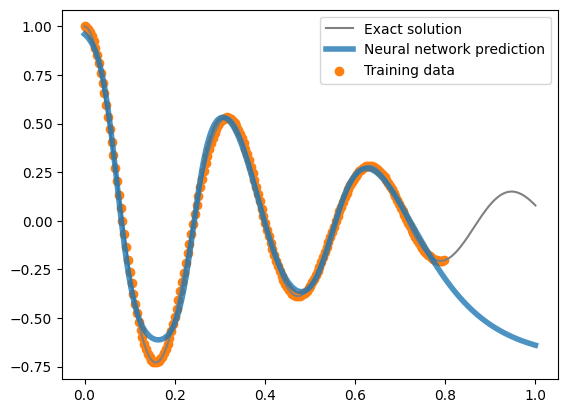

In [685]:
# Denormalize prediction for plotting
y_prediction = []
for x_ev in X_eval:
    y_pred, z_pred = nn_new.propagate_forward(x_ev)
    y_prediction.append(y_pred[-1])
y_pred_array = np.array([y_pred.item() for y_pred in y_prediction]).reshape(-1, 1)
y_pred_array_denorm = 0.5 * (y_pred_array + 1) * (y_max - y_min) + y_min

plt.figure()
plt.plot(x, y, color = "grey", label="Exact solution")
plt.plot(x, y_pred_array_denorm, color="tab:blue", linewidth=4, alpha=0.8, label="Neural network prediction")
plt.scatter(x_data, y_data, color="tab:orange", label="Training data")
plt.legend()
plt.show()